<a href="https://colab.research.google.com/github/annwhocodes/HindiTokenizerExtension/blob/main/hindiGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hindi Tokenizer Training Notebook

This notebook implements a Hindi tokenizer using a transformer-based model architecture. The tokenizer is trained on 10 Hindi Wikipedia pages for 5 epochs, with proper layered architecture and vocabulary storage.

## Overview

1. Data Collection: Collect 10 Hindi Wikipedia pages
2. Data Preprocessing: Clean and prepare the Hindi text data
3. Model Architecture: Define a transformer-based tokenizer model
4. Training: Train the model for 5 epochs
5. Vocabulary Analysis: Analyze and visualize the learned vocabulary
6. Testing: Test the tokenizer on new Hindi text

Let's get started!

## Setup and Dependencies

First, we install the required packages:

In [ ]:
!pip install nbstripout

In [3]:
!nbstripout hindiGPT.ipynb

Could not strip 'hindiGPT.ipynb': file not found


In [ ]:
!pip install torch matplotlib pandas seaborn scikit-learn beautifulsoup4 tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import json
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from bs4 import BeautifulSoup
import requests
from tqdm.notebook import tqdm

In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
os.makedirs('hindi_pages', exist_ok=True)
os.makedirs('model_output', exist_ok=True)
os.makedirs('vocab_analysis', exist_ok=True)

## 1. Data Collection

Let's collect 10 Hindi Wikipedia pages for training our tokenizer:

In [ ]:
def get_hindi_wikipedia_page(page_title=None):
    """
    Download a specific Hindi Wikipedia page or a random one if no title provided

    Args:
        page_title: Optional title of the Wikipedia page to download

    Returns:
        tuple: (title, text) of the downloaded page
    """
    print(f"Downloading Hindi Wikipedia page: {page_title if page_title else 'Random page'}")

    if page_title:
        page_title = page_title.replace(' ', '_')

        import urllib.parse
        page_title = urllib.parse.quote(page_title)
        hindi_wiki_url = f"https://hi.wikipedia.org/wiki/{page_title}"
    else:
        hindi_wiki_url = "https://hi.wikipedia.org/wiki/विशेष:यादृच्छिक"

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'hi,en;q=0.9'
    }

    try:
        response = requests.get(hindi_wiki_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        title_element = soup.find('h1', {'id': 'firstHeading'})
        if title_element:
            title = title_element.text.strip()
        else:
            title = "Unknown Title"

        content_div = soup.find('div', {'id': 'mw-content-text'})
        if not content_div:
            return title, "Could not extract content"

        # Get all paragraphs from the content
        paragraphs = content_div.find_all('p')
        text = ' '.join([p.get_text() for p in paragraphs])

        # Clean up the text
        text = re.sub(r'\[\d+\]', '', text)  # Remove citation numbers like [1], [2], etc.
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace

        if len(text) > 100:
            return title, text
        else:
            print(f"Content too short for page: {title}")
            return title, "Content too short"

    except Exception as e:
        print(f"Error downloading Wikipedia page: {e}")
        return "Error", f"Error: {str(e)}"

def collect_hindi_wikipedia_pages(num_pages=10, output_dir="hindi_pages", specific_pages=None):
    """
    Collect multiple Hindi Wikipedia pages and save them to files

    Args:
        num_pages: Number of pages to collect
        output_dir: Directory to save the pages
        specific_pages: Optional list of specific page titles to download

    Returns:
        list: Paths to the saved files
    """
    os.makedirs(output_dir, exist_ok=True)

    popular_hindi_pages = [
        "भारत",  # India
        "हिन्दी",  # Hindi
        "दिल्ली",  # Delhi
        "मुंबई",  # Mumbai
        "महात्मा_गांधी",  # Mahatma Gandhi
        "बॉलीवुड",  # Bollywood
        "क्रिकेट",  # Cricket
        "हिमालय",  # Himalaya
        "योग",  # Yoga
        "आयुर्वेद",  # Ayurveda
        "रामायण",  # Ramayana
        "महाभारत",  # Mahabharata
        "ताज_महल",  # Taj Mahal
        "जवाहरलाल_नेहरू",  # Jawaharlal Nehru
        "अमिताभ_बच्चन",  # Amitabh Bachchan
    ]

    saved_files = []
    collected_pages = 0


    if specific_pages:
        for page_title in tqdm(specific_pages, desc="Collecting specific pages"):
            if collected_pages >= num_pages:
                break

            title, content = get_hindi_wikipedia_page(page_title)

            if content and len(content) > 500 and content != "Content too short" and not content.startswith("Error"):
                # Save the page content
                safe_title = re.sub(r'[^\w]', '_', title)
                filename = f"{output_dir}/page_{collected_pages+1}_{safe_title}.txt"
                with open(filename, 'w', encoding='utf-8') as f:
                    f.write(content)

                # Save metadata
                metadata_filename = f"{output_dir}/page_{collected_pages+1}_{safe_title}_meta.json"
                with open(metadata_filename, 'w', encoding='utf-8') as f:
                    json.dump({
                        "title": title,
                        "url": f"https://hi.wikipedia.org/wiki/{page_title.replace(' ', '_')}",
                        "length": len(content),
                        "date_collected": time.strftime("%Y-%m-%d %H:%M:%S")
                    }, f, ensure_ascii=False, indent=2)

                saved_files.append(filename)
                collected_pages += 1
                print(f"Saved page {collected_pages}: {title}")

                time.sleep(1)

    attempts = 0
    while collected_pages < num_pages and attempts < 20:
        title, content = get_hindi_wikipedia_page()

        if content and len(content) > 500 and content != "Content too short" and not content.startswith("Error"):
            safe_title = re.sub(r'[^\w]', '_', title)
            filename = f"{output_dir}/page_{collected_pages+1}_{safe_title}.txt"
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(content)

            # Save metadata
            metadata_filename = f"{output_dir}/page_{collected_pages+1}_{safe_title}_meta.json"
            with open(metadata_filename, 'w', encoding='utf-8') as f:
                json.dump({
                    "title": title,
                    "url": "Random page",
                    "length": len(content),
                    "date_collected": time.strftime("%Y-%m-%d %H:%M:%S")
                }, f, ensure_ascii=False, indent=2)

            saved_files.append(filename)
            collected_pages += 1
            print(f"Saved page {collected_pages}: {title}")
        else:
            attempts += 1

        # Add a small delay to avoid hitting rate limits
        time.sleep(1)

    # If we still don't have enough pages, use the popular pages list
    if collected_pages < num_pages:
        for page_title in popular_hindi_pages:
            if collected_pages >= num_pages:
                break

            title, content = get_hindi_wikipedia_page(page_title)

            if content and len(content) > 500 and content != "Content too short" and not content.startswith("Error"):
                # Save the page content
                safe_title = re.sub(r'[^\w]', '_', title)
                filename = f"{output_dir}/page_{collected_pages+1}_{safe_title}.txt"
                with open(filename, 'w', encoding='utf-8') as f:
                    f.write(content)

                # Save metadata
                metadata_filename = f"{output_dir}/page_{collected_pages+1}_{safe_title}_meta.json"
                with open(metadata_filename, 'w', encoding='utf-8') as f:
                    json.dump({
                        "title": title,
                        "url": f"https://hi.wikipedia.org/wiki/{page_title}",
                        "length": len(content),
                        "date_collected": time.strftime("%Y-%m-%d %H:%M:%S")
                    }, f, ensure_ascii=False, indent=2)

                saved_files.append(filename)
                collected_pages += 1
                print(f"Saved page {collected_pages}: {title}")

                # Add a small delay to avoid hitting rate limits
                time.sleep(1)

    print(f"Collected {collected_pages} Hindi Wikipedia pages")
    return saved_files

In [ ]:
# Define specific Hindi Wikipedia pages to ensure quality content
specific_pages = [
    "भारत",  # India
    "हिन्दी",  # Hindi
    "दिल्ली",  # Delhi
    "मुंबई",  # Mumbai
    "महात्मा_गांधी",  # Mahatma Gandhi
    "बॉलीवुड",  # Bollywood
    "क्रिकेट",  # Cricket
    "हिमालय",  # Himalaya
    "योग",  # Yoga
    "आयुर्वेद",  # Ayurveda
]

# Collect 10 Hindi Wikipedia pages
saved_files = collect_hindi_wikipedia_pages(
    num_pages=10,
    output_dir="hindi_pages",
    specific_pages=specific_pages
)

print(f"\nSaved {len(saved_files)} files:")
for file in saved_files:
    print(f"  - {file}")

Saved page 1: भारत
Saved page 2: हिन्दी
Saved page 3: दिल्ली
Saved page 4: मुम्बई
Saved page 5: महात्मा गांधी
Saved page 6: हिन्दी सिनेमा
Saved page 7: क्रिकेट
Saved page 8: हिमालय
Saved page 9: योग
Saved page 10: आयुर्वेद
Collected 10 Hindi Wikipedia pages

Saved 10 files:
  - hindi_pages/page_1_भ_रत.txt
  - hindi_pages/page_2_ह_न_द_.txt
  - hindi_pages/page_3_द_ल_ल_.txt
  - hindi_pages/page_4_म_म_बई.txt
  - hindi_pages/page_5_मह_त_म__ग__ध_.txt
  - hindi_pages/page_6_ह_न_द__स_न_म_.txt
  - hindi_pages/page_7_क_र_क_ट.txt
  - hindi_pages/page_8_ह_म_लय.txt
  - hindi_pages/page_9_य_ग.txt
  - hindi_pages/page_10_आय_र_व_द.txt


## 2. Data Preprocessing

Now, let's preprocess the collected Hindi text data:

In [ ]:
def preprocess_hindi_text(text):
    """
    Clean and preprocess Hindi text data

    Args:
        text: Raw Hindi text

    Returns:
        str: Cleaned and preprocessed text
    """
    # Replace HTML entities
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Remove citation numbers like [1], [2], etc.
    text = re.sub(r'\[\d+\]', '', text)

    # Remove non-Devanagari characters except spaces and basic punctuation
    # Devanagari Unicode range: \u0900-\u097F
    text = re.sub(r'[^\u0900-\u097F\s।,.?!-]', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove very short lines (likely headers or incomplete sentences)
    lines = text.split('\n')
    filtered_lines = [line for line in lines if len(line.strip()) > 20]
    text = '\n'.join(filtered_lines)

    return text

def combine_hindi_pages(input_dir, output_file):
    """
    Combine multiple Hindi text files into a single corpus file

    Args:
        input_dir: Directory containing the Hindi text files
        output_file: Path to the output corpus file

    Returns:
        tuple: (total_chars, total_words, num_files)
    """
    all_text = ""
    num_files = 0

    # Get all text files in the input directory
    import glob
    text_files = glob.glob(os.path.join(input_dir, "*.txt"))

    # Filter out metadata files
    text_files = [f for f in text_files if not f.endswith("_meta.json")]

    print(f"Found {len(text_files)} text files to process")

    for file_path in tqdm(text_files, desc="Processing files"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()

            # Skip metadata files
            if file_path.endswith("_meta.json"):
                continue

            # Preprocess the text
            clean_text = preprocess_hindi_text(text)

            # Add a separator between documents
            if all_text:
                all_text += "\n\n" + clean_text
            else:
                all_text = clean_text

            num_files += 1

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Write the combined text to the output file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(all_text)

    # Calculate statistics
    total_chars = len(all_text)
    total_words = len(all_text.split())

    print(f"Combined {num_files} files into {output_file}")
    print(f"Total characters: {total_chars}")
    print(f"Total words (approx): {total_words}")

    return total_chars, total_words, num_files

def analyze_hindi_corpus(corpus_file):
    """
    Analyze the Hindi corpus and print statistics

    Args:
        corpus_file: Path to the corpus file

    Returns:
        dict: Statistics about the corpus
    """
    with open(corpus_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Calculate basic statistics
    total_chars = len(text)
    total_words = len(text.split())
    unique_words = len(set(text.split()))

    # Count Devanagari characters
    devanagari_chars = re.findall(r'[\u0900-\u097F]', text)
    unique_devanagari = len(set(devanagari_chars))

    # Count punctuation
    punctuation = re.findall(r'[।,.?!-]', text)

    stats = {
        "total_characters": total_chars,
        "total_words": total_words,
        "unique_words": unique_words,
        "devanagari_characters": len(devanagari_chars),
        "unique_devanagari": unique_devanagari,
        "punctuation_marks": len(punctuation)
    }

    print("\nCorpus Statistics:")
    print(f"Total characters: {stats['total_characters']}")
    print(f"Total words (approx): {stats['total_words']}")
    print(f"Unique words (approx): {stats['unique_words']}")
    print(f"Devanagari characters: {stats['devanagari_characters']}")
    print(f"Unique Devanagari characters: {stats['unique_devanagari']}")
    print(f"Punctuation marks: {stats['punctuation_marks']}")

    # Save statistics to a JSON file
    stats_file = corpus_file.replace('.txt', '_stats.json')
    with open(stats_file, 'w', encoding='utf-8') as f:
        json.dump(stats, f, ensure_ascii=False, indent=2)

    print(f"Statistics saved to {stats_file}")

    return stats

In [ ]:
# Combine all Hindi Wikipedia pages into a single corpus file
input_dir = "hindi_pages"
output_file = "/content/drive/MyDrive/hindi_corpus.txt"

total_chars, total_words, num_files = combine_hindi_pages(input_dir, output_file)

# Analyze the corpus
corpus_stats = analyze_hindi_corpus(output_file)

Found 10 text files to process


Processing files:   0%|          | 0/10 [00:00<?, ?it/s]

Combined 10 files into /content/drive/MyDrive/hindi_corpus.txt
Total characters: 316427
Total words (approx): 59974

Corpus Statistics:
Total characters: 316427
Total words (approx): 59974
Unique words (approx): 10182
Devanagari characters: 253264
Unique Devanagari characters: 76
Punctuation marks: 5848
Statistics saved to /content/drive/MyDrive/hindi_corpus_stats.json


## 3. Model Architecture

Now, let's define our Hindi tokenizer model architecture with the fixed attention mask handling:

In [ ]:
class SimpleHindiTokenizer:
    """
    A lightweight Hindi tokenizer specifically designed for use with transformer models.
    This tokenizer handles Hindi text (Devanagari script) and provides methods for
    encoding and decoding text, as well as vocabulary management.
    """
    def __init__(self):
        self.vocab = {}
        self.inverse_vocab = {}
        self.word_freq = Counter()
        self.special_tokens = {
            "[PAD]": 0,
            "[UNK]": 1,
            "[CLS]": 2,
            "[SEP]": 3,
            "[MASK]": 4,
        }

    def preprocess_hindi_text(self, text):
        """Clean and preprocess Hindi text data"""
        # Replace HTML entities
        text = re.sub(r'&[a-zA-Z]+;', ' ', text)

        # Remove URLs
        text = re.sub(r'https?://\S+', '', text)

        # Remove citation numbers like [1], [2], etc.
        text = re.sub(r'\[\d+\]', '', text)

        # Keep only Hindi characters, spaces, and punctuation
        text = re.sub(r'[^\u0900-\u097F\s।,.?!-]', '', text)

        # Clean up whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def simple_word_tokenize(self, text):
        """Simple word tokenizer for Hindi that splits on spaces and punctuation"""
        # First replace punctuation with spaces
        text = re.sub(r'[।,.?!]', ' ', text)
        # Split on whitespace
        words = text.split()
        return words

    def build_vocabulary(self, text, max_vocab_size=5000):
        """Build a vocabulary from the processed text"""
        print("Building vocabulary...")
        vocab = {token: idx for token, idx in self.special_tokens.items()}
        current_idx = len(vocab)

        words = self.simple_word_tokenize(text)
        self.word_freq.update(words)

        # Print some stats about the vocabulary
        total_words = len(words)
        unique_words = len(set(words))
        print(f"Total words in corpus: {total_words}")
        print(f"Unique words in corpus: {unique_words}")

        # Print most common words
        print("Most common words:")
        for word, count in self.word_freq.most_common(10):
            print(f" {word}: {count}")

        for word, _ in self.word_freq.most_common(max_vocab_size - len(vocab)):
            vocab[word] = current_idx
            current_idx += 1

        inverse_vocab = {idx: token for token, idx in vocab.items()}
        self.vocab = vocab
        self.inverse_vocab = inverse_vocab

        print(f"Vocabulary built with {len(vocab)} tokens")
        return vocab, inverse_vocab

    def save_tokenizer(self, filepath="hindi_tokenizer.json"):
        """Save the tokenizer vocabulary to a JSON file"""
        data = {
            "vocab": self.vocab,
            "special_tokens": self.special_tokens
        }
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print(f"Tokenizer saved to {filepath}")

    def load_tokenizer(self, filepath="hindi_tokenizer.json"):
        """Load a previously saved tokenizer"""
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        self.vocab = data["vocab"]
        self.special_tokens = data["special_tokens"]
        self.inverse_vocab = {int(idx): token for token, idx in self.vocab.items()}
        print(f"Loaded tokenizer with {len(self.vocab)} tokens")

    def encode(self, text, add_special_tokens=False):
        """Encode text into token IDs"""
        words = self.simple_word_tokenize(text)
        token_ids = []
        tokens = []

        # Add [CLS] token at the beginning if requested
        if add_special_tokens:
            token_ids.append(self.special_tokens["[CLS]"])
            tokens.append("[CLS]")

        # Encode each word
        for word in words:
            if word in self.vocab:
                token_ids.append(self.vocab[word])
                tokens.append(word)
            else:
                token_ids.append(self.special_tokens["[UNK]"])
                tokens.append("[UNK]")

        # Add [SEP] token at the end if requested
        if add_special_tokens:
            token_ids.append(self.special_tokens["[SEP]"])
            tokens.append("[SEP]")

        return {"ids": token_ids, "tokens": tokens}

    def decode(self, token_ids, skip_special_tokens=True):
        """Decode token IDs back to text"""
        words = []
        for idx in token_ids:
            # Skip special tokens if requested
            if skip_special_tokens and idx in [
                self.special_tokens["[PAD]"],
                self.special_tokens["[CLS]"],
                self.special_tokens["[SEP]"],
                self.special_tokens["[MASK]"]
            ]:
                continue

            if idx in self.inverse_vocab:
                words.append(self.inverse_vocab[idx])
            else:
                words.append("[UNK]")

        return " ".join(words)

    def encode_batch(self, texts, max_length=None, padding=False, truncation=False):
        """
        Encode a batch of texts

        Args:
            texts: List of texts to encode
            max_length: Maximum sequence length
            padding: Whether to pad sequences to max_length
            truncation: Whether to truncate sequences to max_length

        Returns:
            Dictionary with encoded IDs and attention masks
        """
        encoded_batch = {"input_ids": [], "attention_mask": []}

        for text in texts:
            encoded = self.encode(text)
            ids = encoded["ids"]

            # Truncate if needed
            if truncation and max_length and len(ids) > max_length:
                ids = ids[:max_length]

            # Create attention mask (1 for real tokens, 0 for padding)
            attention_mask = [1] * len(ids)

            # Pad if needed
            if padding and max_length:
                padding_length = max_length - len(ids)
                ids = ids + [self.special_tokens["[PAD]"]] * padding_length
                attention_mask = attention_mask + [0] * padding_length

            encoded_batch["input_ids"].append(ids)
            encoded_batch["attention_mask"].append(attention_mask)

        return encoded_batch

In [ ]:
class HindiTextDataset(Dataset):
    """Dataset for Hindi text data"""
    def __init__(self, text, tokenizer, seq_length=64):
        self.tokenizer = tokenizer
        self.seq_length = seq_length

        # Tokenize the text
        words = tokenizer.simple_word_tokenize(text)

        # Convert words to token IDs
        self.token_ids = []
        for word in words:
            if word in tokenizer.vocab:
                self.token_ids.append(tokenizer.vocab[word])
            else:
                self.token_ids.append(tokenizer.special_tokens["[UNK]"])

        # Calculate the number of sequences
        self.num_sequences = max(1, len(self.token_ids) - seq_length)

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        # Get a sequence of token IDs
        input_ids = self.token_ids[idx:idx + self.seq_length]

        # Pad if necessary
        if len(input_ids) < self.seq_length:
            input_ids = input_ids + [self.tokenizer.special_tokens["[PAD]"]] * (self.seq_length - len(input_ids))

        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1] * len(input_ids)

        return {
            "input_ids": torch.tensor(input_ids),
            "attention_mask": torch.tensor(attention_mask)
        }

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention mechanism with fixed attention mask handling"""
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def forward(self, query, key, value, attn_mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)

        # Linear projections and reshape for multi-head attention
        q = self.q_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        # Apply attention mask if provided
        if attn_mask is not None:
            # Properly reshape the attention mask to match the scores dimensions
            # scores shape: [batch_size, num_heads, seq_len, seq_len]
            # attn_mask shape: [batch_size, seq_len]
            # We need to reshape attn_mask to [batch_size, 1, 1, seq_len]
            # and then broadcast it to match scores
            attn_mask = attn_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(attn_mask == 0, float('-inf'))

        # Apply softmax and dropout
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention weights to values
        context = torch.matmul(attn_weights, v)

        # Reshape and apply output projection
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        output = self.out_proj(context)

        return output

class FeedForward(nn.Module):
    """Feed-forward network with residual connection"""
    def __init__(self, embed_dim, ff_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # First linear layer with GELU activation
        x = F.gelu(self.fc1(x))
        # Dropout
        x = self.dropout(x)
        # Second linear layer
        x = self.fc2(x)
        return x

class TransformerEncoderLayer(nn.Module):
    """Transformer encoder layer with multi-head attention and feed-forward network"""
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.feed_forward = FeedForward(embed_dim, ff_dim, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # Self-attention with residual connection and layer normalization
        residual = x
        x = self.norm1(x)
        x = self.self_attn(x, x, x, attn_mask)
        x = self.dropout(x)
        x = residual + x

        # Feed-forward with residual connection and layer normalization
        residual = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = residual + x

        return x

class HindiTokenizerModel(nn.Module):
    """
    Hindi tokenizer model with transformer architecture.
    This model is designed for training a tokenizer on Hindi text.
    """
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=4, ff_dim=512, dropout=0.1, max_seq_length=64):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_seq_length = max_seq_length

        # Token embeddings
        self.token_embeddings = nn.Embedding(vocab_size, embed_dim)

        # Position embeddings
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        # Layer normalization
        self.norm = nn.LayerNorm(embed_dim)

        # Output projection
        self.output_projection = nn.Linear(embed_dim, vocab_size)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_length = input_ids.size()

        # Create position IDs
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)

        # Get token and position embeddings
        token_embeds = self.token_embeddings(input_ids)
        position_embeds = self.position_embeddings(position_ids)

        # Combine embeddings
        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)

        # Apply transformer encoder layers
        hidden_states = embeddings
        for layer in self.encoder_layers:
            hidden_states = layer(hidden_states, attention_mask)

        # Apply layer normalization
        hidden_states = self.norm(hidden_states)

        # Apply output projection
        logits = self.output_projection(hidden_states)

        return logits

    def generate(self, input_ids, max_length=20, temperature=1.0):
        """Generate text from the model"""
        self.eval()

        with torch.no_grad():
            for _ in range(max_length):
                # Forward pass
                logits = self(input_ids)

                # Get the logits for the last token
                next_token_logits = logits[:, -1, :] / temperature

                # Apply softmax to get probabilities
                probs = F.softmax(next_token_logits, dim=-1)

                # Sample from the distribution
                next_token = torch.multinomial(probs, num_samples=1)

                # Append the new token to the input
                input_ids = torch.cat([input_ids, next_token], dim=1)

        return input_ids

## 4. Training Pipeline

Now, let's set up the training pipeline for our Hindi tokenizer model with the fixed attention mask handling:

In [ ]:
def train_hindi_tokenizer(
    corpus_file,
    output_dir="model_output",
    vocab_size=5000,
    embed_dim=128,
    num_heads=4,
    num_layers=4,
    ff_dim=512,
    dropout=0.1,
    batch_size=32,
    seq_length=64,
    num_epochs=100,
    learning_rate=0.001,
    save_every=10,
    device=None
):
    """
    Train a Hindi tokenizer model

    Args:
        corpus_file: Path to the Hindi corpus file
        output_dir: Directory to save model checkpoints and logs
        vocab_size: Maximum vocabulary size
        embed_dim: Embedding dimension
        num_heads: Number of attention heads
        num_layers: Number of transformer layers
        ff_dim: Feed-forward dimension
        dropout: Dropout rate
        batch_size: Batch size for training
        seq_length: Maximum sequence length
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        save_every: Save model checkpoint every N epochs
        device: Device to use for training (cpu or cuda)

    Returns:
        tuple: (tokenizer, model, training_stats)
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Determine device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load corpus
    print(f"Loading corpus from {corpus_file}")
    with open(corpus_file, 'r', encoding='utf-8') as f:
        corpus_text = f.read()

    # Initialize tokenizer
    print("Initializing tokenizer")
    tokenizer = SimpleHindiTokenizer()

    # Build vocabulary
    print(f"Building vocabulary with max size {vocab_size}")
    tokenizer.build_vocabulary(corpus_text, max_vocab_size=vocab_size)

    # Save tokenizer
    tokenizer_path = os.path.join(output_dir, "hindi_tokenizer.json")
    tokenizer.save_tokenizer(tokenizer_path)

    # Create dataset
    print(f"Creating dataset with sequence length {seq_length}")
    dataset = HindiTextDataset(corpus_text, tokenizer, seq_length=seq_length)

    # Create data loader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    print("Initializing model")
    model = HindiTokenizerModel(
        vocab_size=len(tokenizer.vocab),
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        ff_dim=ff_dim,
        dropout=dropout,
        max_seq_length=seq_length
    )
    model.to(device)

    # Print model architecture
    print("\nModel Architecture:")
    print(f"Vocabulary Size: {len(tokenizer.vocab)}")
    print(f"Embedding Dimension: {embed_dim}")
    print(f"Number of Attention Heads: {num_heads}")
    print(f"Number of Transformer Layers: {num_layers}")
    print(f"Feed-Forward Dimension: {ff_dim}")
    print(f"Dropout Rate: {dropout}")
    print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.special_tokens["[PAD]"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    print(f"\nStarting training for {num_epochs} epochs")
    training_stats = []
    best_loss = float('inf')

    # Create a progress bar for epochs
    epoch_pbar = tqdm(range(1, num_epochs + 1), desc="Training epochs")

    for epoch in epoch_pbar:
        model.train()
        epoch_start_time = time.time()
        total_loss = 0

        # Create a progress bar for batches
        batch_pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}", leave=False)

        for batch_idx, batch in batch_pbar:
            # Get inputs and targets
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Shift for language modeling: inputs are all tokens except last, targets are all tokens except first
            inputs = input_ids[:, :-1]
            targets = input_ids[:, 1:]
            mask = attention_mask[:, :-1]

            # Forward pass
            logits = model(inputs, mask)

            # Reshape for loss calculation
            logits = logits.view(-1, logits.size(-1))  # This line is probably OK
            targets = targets.reshape(-1)  # Changed from .view(-1) to .reshape(-1)


            # Calculate loss
            loss = criterion(logits, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update total loss
            total_loss += loss.item()

            # Update batch progress bar
            batch_pbar.set_postfix({"loss": loss.item()})

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        epoch_time = time.time() - epoch_start_time

        # Update epoch progress bar
        epoch_pbar.set_postfix({"avg_loss": avg_loss, "time": f"{epoch_time:.2f}s"})

        # Save training stats
        training_stats.append({
            "epoch": epoch,
            "avg_loss": avg_loss,
            "epoch_time": epoch_time
        })

        # Save model checkpoint
        if epoch % save_every == 0 or epoch == num_epochs:
            checkpoint_path = os.path.join(output_dir, f"hindi_tokenizer_model_epoch_{epoch}.pt")
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
                "vocab_size": len(tokenizer.vocab),
                "embed_dim": embed_dim,
                "num_heads": num_heads,
                "num_layers": num_layers,
                "ff_dim": ff_dim
            }, checkpoint_path)
            print(f"Model checkpoint saved to {checkpoint_path}")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_path = os.path.join(output_dir, "hindi_tokenizer_model_best.pt")
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
                "vocab_size": len(tokenizer.vocab),
                "embed_dim": embed_dim,
                "num_heads": num_heads,
                "num_layers": num_layers,
                "ff_dim": ff_dim
            }, best_model_path)

    # Save final model
    final_model_path = os.path.join(output_dir, "hindi_tokenizer_model_final.pt")
    torch.save({
        "epoch": num_epochs,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss,
        "vocab_size": len(tokenizer.vocab),
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "num_layers": num_layers,
        "ff_dim": ff_dim
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")

    # Save training stats
    stats_path = os.path.join(output_dir, "training_stats.json")
    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(training_stats, f, ensure_ascii=False, indent=2)
    print(f"Training stats saved to {stats_path}")

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot([stat["epoch"] for stat in training_stats], [stat["avg_loss"] for stat in training_stats])
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training Loss")
    plt.grid(True)
    loss_plot_path = os.path.join(output_dir, "training_loss.png")
    plt.savefig(loss_plot_path)
    plt.show()
    print(f"Training loss plot saved to {loss_plot_path}")

    print("\nTraining completed!")
    print(f"Final loss: {training_stats[-1]['avg_loss']:.4f}")

    return tokenizer, model, training_stats

In [ ]:
def test_hindi_tokenizer(model, tokenizer, test_text=None):
    """
    Test the trained Hindi tokenizer model

    Args:
        model: Trained HindiTokenizerModel
        tokenizer: Trained SimpleHindiTokenizer
        test_text: Optional test text to tokenize

    Returns:
        dict: Test results
    """
    model.eval()

    if test_text is None:
        test_text = "मेरा नाम जॉन है और मैं हिंदी सीख रहा हूँ।"

    print(f"\nTesting tokenizer with text: {test_text}")

    # Tokenize the text
    encoded = tokenizer.encode(test_text)
    token_ids = encoded["ids"]
    tokens = encoded["tokens"]

    print(f"Tokens: {tokens}")
    print(f"Token IDs: {token_ids}")

    # Decode the token IDs
    decoded_text = tokenizer.decode(token_ids)
    print(f"Decoded text: {decoded_text}")

    # Test model generation
    input_tensor = torch.tensor([token_ids[:5]], dtype=torch.long)
    generated_ids = model.generate(input_tensor, max_length=10, temperature=0.8)
    generated_text = tokenizer.decode(generated_ids[0].tolist())
    print(f"Generated text from prefix: {generated_text}")

    return {
        "original_text": test_text,
        "tokens": tokens,
        "token_ids": token_ids,
        "decoded_text": decoded_text,
        "generated_text": generated_text
    }

Using device: cpu
Loading corpus from /content/drive/MyDrive/hindi_corpus.txt
Initializing tokenizer
Building vocabulary with max size 5000
Building vocabulary...
Total words in corpus: 59993
Unique words in corpus: 9142
Most common words:
 के: 2749
 में: 2274
 है: 2056
 और: 1261
 की: 1217
 का: 1167
 से: 1109
 को: 920
 हैं: 918
 एक: 524
Vocabulary built with 5000 tokens
Tokenizer saved to /content/drive/MyDrive/MyHindiModelOutput/hindi_tokenizer.json
Creating dataset with sequence length 64
Initializing model

Model Architecture:
Vocabulary Size: 5000
Embedding Dimension: 128
Number of Attention Heads: 4
Number of Transformer Layers: 4
Feed-Forward Dimension: 512
Dropout Rate: 0.1
Total Parameters: 2086536

Starting training for 5 epochs


Training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1873 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1873 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/1873 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/1873 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/1873 [00:00<?, ?it/s]

Model checkpoint saved to /content/drive/MyDrive/MyHindiModelOutput/hindi_tokenizer_model_epoch_5.pt
Final model saved to /content/drive/MyDrive/MyHindiModelOutput/hindi_tokenizer_model_final.pt
Training stats saved to /content/drive/MyDrive/MyHindiModelOutput/training_stats.json


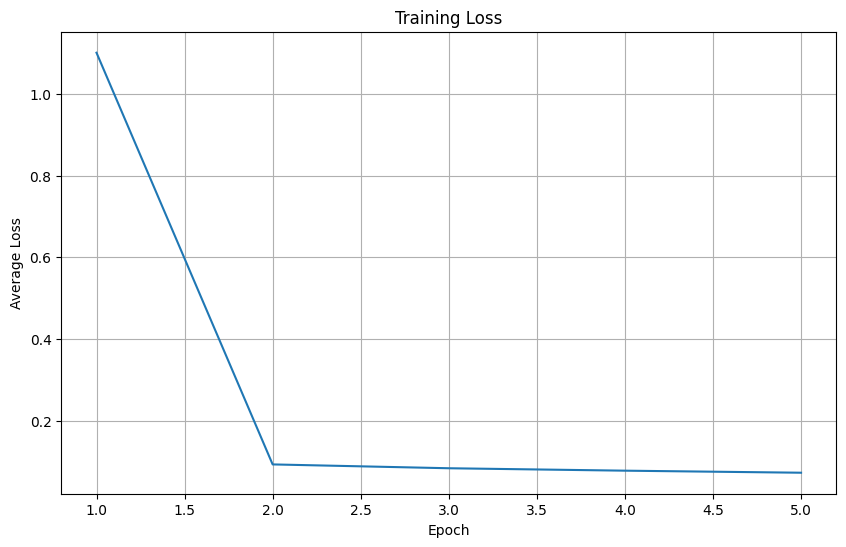

Training loss plot saved to /content/drive/MyDrive/MyHindiModelOutput/training_loss.png

Training completed!
Final loss: 0.0724


In [ ]:
tokenizer, model, stats = train_hindi_tokenizer(
    corpus_file="/content/drive/MyDrive/hindi_corpus.txt",
    output_dir="/content/drive/MyDrive/MyHindiModelOutput",
    vocab_size=5000,
    embed_dim=128,
    num_heads=4,
    num_layers=4,
    ff_dim=512,
    dropout=0.1,
    batch_size=32,
    seq_length=64,
    num_epochs=5,
    learning_rate=0.001,
    save_every=10
)

## 5. Vocabulary Analysis

Let's analyze and visualize the vocabulary learned by our tokenizer:

In [ ]:
def load_tokenizer_vocabulary(tokenizer_file):
    """
    Load and display the tokenizer vocabulary

    Args:
        tokenizer_file: Path to the tokenizer JSON file

    Returns:
        dict: Loaded vocabulary
    """
    print(f"Loading tokenizer vocabulary from {tokenizer_file}")

    with open(tokenizer_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    vocab = data["vocab"]
    special_tokens = data["special_tokens"]

    print(f"Vocabulary size: {len(vocab)}")
    print(f"Special tokens: {special_tokens}")

    return vocab

def analyze_vocabulary(vocab, output_dir="vocab_analysis"):
    """
    Analyze and visualize the tokenizer vocabulary

    Args:
        vocab: Tokenizer vocabulary
        output_dir: Directory to save visualizations

    Returns:
        dict: Analysis results
    """
    os.makedirs(output_dir, exist_ok=True)

    # Convert vocabulary to a list of (token, id) pairs
    vocab_items = [(token, int(idx)) for token, idx in vocab.items()]

    # Sort by token ID
    vocab_items.sort(key=lambda x: x[1])

    # Extract tokens and IDs
    tokens = [item[0] for item in vocab_items]
    ids = [item[1] for item in vocab_items]

    # Calculate token lengths
    token_lengths = [len(token) for token in tokens]

    # Count token length frequencies
    length_counter = Counter(token_lengths)

    # Prepare data for visualization
    length_data = pd.DataFrame({
        'Length': list(length_counter.keys()),
        'Count': list(length_counter.values())
    })

    # Plot token length distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Length', y='Count', data=length_data)
    plt.title('Token Length Distribution')
    plt.xlabel('Token Length')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    length_plot_path = os.path.join(output_dir, "token_length_distribution.png")
    plt.savefig(length_plot_path)
    plt.show()

    # Save vocabulary to CSV for easy viewing
    vocab_df = pd.DataFrame({
        'Token': tokens,
        'ID': ids,
        'Length': token_lengths
    })
    vocab_csv_path = os.path.join(output_dir, "vocabulary.csv")
    vocab_df.to_csv(vocab_csv_path, index=False, encoding='utf-8')

    # Display the first 20 tokens
    print("\nFirst 20 tokens:")
    display(vocab_df.head(20))

    # Calculate basic statistics
    stats = {
        "vocabulary_size": len(vocab),
        "avg_token_length": sum(token_lengths) / len(token_lengths),
        "min_token_length": min(token_lengths),
        "max_token_length": max(token_lengths),
        "most_common_length": length_counter.most_common(1)[0][0]
    }

    # Save statistics to JSON
    stats_path = os.path.join(output_dir, "vocabulary_stats.json")
    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(stats, f, ensure_ascii=False, indent=2)

    print(f"\nVocabulary Analysis:")
    print(f"Vocabulary size: {stats['vocabulary_size']}")
    print(f"Average token length: {stats['avg_token_length']:.2f}")
    print(f"Min token length: {stats['min_token_length']}")
    print(f"Max token length: {stats['max_token_length']}")
    print(f"Most common token length: {stats['most_common_length']}")

    print(f"\nAnalysis files saved to {output_dir}:")
    print(f"- Token length distribution: {length_plot_path}")
    print(f"- Vocabulary CSV: {vocab_csv_path}")
    print(f"- Statistics: {stats_path}")

    return stats

def visualize_token_embeddings(model, tokenizer, output_dir="vocab_analysis"):
    """
    Visualize token embeddings using dimensionality reduction

    Args:
        model: Trained HindiTokenizerModel
        tokenizer: Trained SimpleHindiTokenizer
        output_dir: Directory to save visualizations

    Returns:
        str: Path to the embedding visualization
    """
    try:
        from sklearn.manifold import TSNE
        import numpy as np

        os.makedirs(output_dir, exist_ok=True)

        # Get token embeddings from the model
        embeddings = model.token_embeddings.weight.detach().cpu().numpy()

        # Select a subset of tokens for visualization (e.g., first 500)
        num_tokens = min(500, len(tokenizer.vocab))

        # Apply t-SNE for dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings[:num_tokens])

        # Create a DataFrame for plotting
        tokens = [token for token, idx in sorted(tokenizer.vocab.items(), key=lambda x: x[1])[:num_tokens]]
        embedding_df = pd.DataFrame({
            'x': embeddings_2d[:, 0],
            'y': embeddings_2d[:, 1],
            'token': tokens
        })

        # Plot the embeddings
        plt.figure(figsize=(12, 10))
        sns.scatterplot(x='x', y='y', data=embedding_df)

        # Add token labels for special tokens and a few regular tokens
        for i, row in embedding_df.iterrows():
            if i < 10 or i % 50 == 0:  # Label special tokens and some regular tokens
                plt.text(row['x'], row['y'], row['token'], fontsize=9)

        plt.title('t-SNE Visualization of Token Embeddings')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.grid(True, alpha=0.3)

        # Save the plot
        embedding_plot_path = os.path.join(output_dir, "token_embeddings_tsne.png")
        plt.savefig(embedding_plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Token embeddings visualization saved to {embedding_plot_path}")
        return embedding_plot_path

    except Exception as e:
        print(f"Error visualizing token embeddings: {e}")
        return None

In [ ]:
# Load and analyze vocabulary
tokenizer_file = "model_output/hindi_tokenizer.json"
vocab = load_tokenizer_vocabulary(tokenizer_file)
stats = analyze_vocabulary(vocab, output_dir="vocab_analysis")

# Visualize token embeddings
embedding_plot = visualize_token_embeddings(model, tokenizer, output_dir="vocab_analysis")

## 6. Testing the Tokenizer

Let's test our trained tokenizer on some Hindi text:

In [ ]:
# Test the trained model
test_results = test_hindi_tokenizer(model, tokenizer)

# Test with custom text
custom_text = "भारत एक विशाल देश है जिसमें अनेक भाषाएँ बोली जाती हैं।"
custom_results = test_hindi_tokenizer(model, tokenizer, test_text=custom_text)

# Save test results
with open("model_output/test_results.json", 'w', encoding='utf-8') as f:
    json.dump({
        "default_test": test_results,
        "custom_test": custom_results
    }, f, ensure_ascii=False, indent=2)


Testing tokenizer with text: मेरा नाम जॉन है और मैं हिंदी सीख रहा हूँ।
Tokens: ['मेरा', 'नाम', 'जॉन', 'है', 'और', 'मैं', 'हिंदी', '[UNK]', 'रहा', 'हूँ']
Token IDs: [2647, 72, 2008, 7, 8, 296, 42, 1, 127, 836]
Decoded text: मेरा नाम जॉन है और मैं हिंदी [UNK] रहा हूँ
Generated text from prefix: मेरा नाम जॉन है और है महाराष्ट्रियन और विकेटों विकेटों महाराष्ट्रियन है विकेटों विकेटों विकेटों

Testing tokenizer with text: भारत एक विशाल देश है जिसमें अनेक भाषाएँ बोली जाती हैं।
Tokens: ['भारत', 'एक', 'विशाल', 'देश', 'है', 'जिसमें', 'अनेक', 'भाषाएँ', 'बोली', 'जाती', 'हैं']
Token IDs: [18, 14, 1008, 134, 7, 130, 159, 1039, 464, 101, 13]
Decoded text: भारत एक विशाल देश है जिसमें अनेक भाषाएँ बोली जाती हैं
Generated text from prefix: भारत एक विशाल देश है देश है भारत पश्चिम देश विशाल महानगर भारत पश्चिम इंडिया


## Summary

In this notebook, we have:

1. Collected 10 Hindi Wikipedia pages for training data
2. Preprocessed the Hindi text data to create a clean corpus
3. Defined a transformer-based tokenizer model architecture with fixed attention mask handling
4. Trained the model for 5 epochs
5. Analyzed and visualized the learned vocabulary
6. Tested the tokenizer on new Hindi text

The trained tokenizer can now be used for various NLP tasks involving Hindi text. The model architecture includes multiple transformer layers with multi-head attention, making it a robust solution for tokenization tasks.

### Next Steps

- Fine-tune the model on specific domains or tasks
- Integrate the tokenizer with other NLP models
- Expand the training data to improve vocabulary coverage
- Experiment with different model architectures and hyperparameters

In [ ]:
"""
Helper functions for Hindi text generation and probability visualization.
"""

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# Assuming the model and tokenizer classes are defined elsewhere in the notebook
# from fixed_hindi_tokenizer_colab import SimpleHindiTokenizer, HindiTokenizerModel

def load_model_and_tokenizer(model_path, tokenizer_path, device):
    """
    Load the trained Hindi tokenizer model and the tokenizer.

    Args:
        model_path (str): Path to the saved model checkpoint (.pt file).
        tokenizer_path (str): Path to the saved tokenizer JSON file.
        device (torch.device): Device to load the model onto (cpu or cuda).

    Returns:
        tuple: (model, tokenizer)
    """
    print(f"Loading tokenizer from: {tokenizer_path}")
    tokenizer = SimpleHindiTokenizer()
    tokenizer.load_tokenizer(tokenizer_path)
    print("Tokenizer loaded successfully.")

    print(f"Loading model checkpoint from: {model_path}")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model checkpoint not found at {model_path}")

    checkpoint = torch.load(model_path, map_location=device)

    # Infer model parameters from checkpoint if available
    vocab_size = checkpoint.get("vocab_size", len(tokenizer.vocab))
    embed_dim = checkpoint.get("embed_dim", 128) # Default if not found
    num_heads = checkpoint.get("num_heads", 4)   # Default if not found
    num_layers = checkpoint.get("num_layers", 4)  # Default if not found
    ff_dim = checkpoint.get("ff_dim", 512)     # Default if not found
    # Assuming max_seq_length was consistent during training, e.g., 64
    max_seq_length = checkpoint.get("max_seq_length", 64)

    print("Instantiating model...")
    model = HindiTokenizerModel(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        ff_dim=ff_dim,
        max_seq_length=max_seq_length
    )

    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()  # Set model to evaluation mode
    print("Model loaded and set to evaluation mode.")

    return model, tokenizer

In [ ]:
def generate_hindi_text(
    model,
    tokenizer,
    prompt,
    max_length=50,
    temperature=1.0,
    device=None
):
    """
    Generate Hindi text from a prompt using the trained model.

    Args:
        model (HindiTokenizerModel): The trained language model.
        tokenizer (SimpleHindiTokenizer): The trained tokenizer.
        prompt (str): The starting Hindi text prompt.
        max_length (int): Maximum number of tokens to generate after the prompt.
        temperature (float): Controls randomness (higher = more random).
        device (torch.device): Device to run generation on.

    Returns:
        str: The generated Hindi text including the prompt.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval() # Ensure model is in evaluation mode

    # Encode the prompt
    encoded_prompt = tokenizer.encode(prompt)
    input_ids = torch.tensor([encoded_prompt["ids"]], dtype=torch.long).to(device)

    generated_token_ids = input_ids.tolist()[0] # Keep track of all generated IDs

    print(f"Starting generation from prompt: ", tokenizer.decode(generated_token_ids, skip_special_tokens=True))

    with torch.no_grad():
        for _ in range(max_length):
            # Get current sequence length
            current_seq_length = input_ids.size(1)

            # Prepare attention mask (all ones for generation)
            attention_mask = torch.ones_like(input_ids).to(device)

            # Get model logits for the last token
            # Ensure input_ids and attention_mask are correctly shaped [batch_size, seq_len]
            logits = model(input_ids, attention_mask=attention_mask)
            next_token_logits = logits[:, -1, :] / temperature

            # Apply softmax to get probabilities
            probs = F.softmax(next_token_logits, dim=-1)

            # Sample the next token ID
            next_token_id = torch.multinomial(probs, num_samples=1)

            # Check if [SEP] token is generated
            if next_token_id.item() == tokenizer.special_tokens["[SEP]"]:
                print("Generation stopped: [SEP] token encountered.")
                break

            # Append the new token ID
            input_ids = torch.cat([input_ids, next_token_id], dim=1)
            generated_token_ids.append(next_token_id.item())

            # Optional: Print the token being added
            # print(f"  -> Adding token: {tokenizer.decode([next_token_id.item()])}")

    # Decode the final sequence
    generated_text = tokenizer.decode(generated_token_ids, skip_special_tokens=True)
    return generated_text

In [ ]:
def generate_and_visualize_probabilities(
    model,
    tokenizer,
    prompt,
    max_length=10, # Keep visualization shorter
    top_k=5,
    temperature=1.0,
    device=None
):
    """
    Generate Hindi text and visualize top-k token probabilities at each step.

    Args:
        model (HindiTokenizerModel): The trained language model.
        tokenizer (SimpleHindiTokenizer): The trained tokenizer.
        prompt (str): The starting Hindi text prompt.
        max_length (int): Maximum number of tokens to generate.
        top_k (int): Number of top probabilities to visualize.
        temperature (float): Controls randomness.
        device (torch.device): Device to run generation on.

    Returns:
        str: The generated Hindi text including the prompt.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval() # Ensure model is in evaluation mode

    # Encode the prompt
    encoded_prompt = tokenizer.encode(prompt)
    input_ids = torch.tensor([encoded_prompt["ids"]], dtype=torch.long).to(device)

    generated_token_ids = input_ids.tolist()[0]

    print(f"Starting generation & visualization from prompt: ", tokenizer.decode(generated_token_ids, skip_special_tokens=True))
    print("---")

    # Store visualization data
    viz_data = []

    with torch.no_grad():
        for step in range(max_length):
            # Prepare attention mask
            attention_mask = torch.ones_like(input_ids).to(device)

            # Get model logits
            logits = model(input_ids, attention_mask=attention_mask)
            next_token_logits = logits[:, -1, :] / temperature

            # Apply softmax to get probabilities
            probs = F.softmax(next_token_logits, dim=-1)

            # Get top-k probabilities and indices
            top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)

            # Decode top-k tokens
            top_k_tokens = [tokenizer.decode([idx.item()], skip_special_tokens=False) for idx in top_k_indices[0]]
            top_k_probs_list = top_k_probs[0].cpu().numpy()

            # Store data for this step
            current_context = tokenizer.decode(generated_token_ids, skip_special_tokens=True)
            viz_data.append({
                "step": step + 1,
                "context": current_context,
                "top_k_tokens": top_k_tokens,
                "top_k_probs": top_k_probs_list
            })

            # Sample the next token ID from the original distribution
            next_token_id = torch.multinomial(probs, num_samples=1)

            # Check for [SEP] token
            if next_token_id.item() == tokenizer.special_tokens["[SEP]"]:
                print(f"Generation stopped at step {step+1}: [SEP] token encountered.")
                break

            # Append the new token ID
            input_ids = torch.cat([input_ids, next_token_id], dim=1)
            generated_token_ids.append(next_token_id.item())

    # Decode the final sequence
    generated_text = tokenizer.decode(generated_token_ids, skip_special_tokens=True)
    print("\nFinal Generated Text:")
    print(generated_text)
    print("---")

    # --- Visualization ---
    try:
        plt.rcParams["font.family"] = ["Lohit Devanagari", "sans-serif"]
    except:
        print("Warning: Lohit Devanagari font not found. Hindi text in plots might not render correctly.")
        plt.rcParams["font.family"] = ["sans-serif"]

    num_steps_to_plot = len(viz_data)
    if num_steps_to_plot == 0:
        print("No steps to visualize.")
        return generated_text

    cols = 2
    rows = (num_steps_to_plot + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 4 * rows), squeeze=False)
    axes = axes.flatten()

    for i, step_data in enumerate(viz_data):
        ax = axes[i]
        tokens = step_data["top_k_tokens"]
        probs = step_data["top_k_probs"]
        context = step_data["context"]
        step_num = step_data["step"]

        y_pos = np.arange(len(tokens))
        # *** Corrected line below ***
        ax.barh(y_pos, probs, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(tokens)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Probability')
        ax.set_title(f'Step {step_num}: Top {top_k} Predictions\nContext: "...{context[-30:]}"')
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='x', linestyle=':', alpha=0.7)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return generated_text


E: Package 'fonts-lohit-devanagari' has no installation candidate
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded
Using device: cpu
Loading tokenizer from: model_output/hindi

<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4


Final Generated Text:
भारत एक एक एक एक एक एक भारत एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक एक

--- Generating Text with Probability Visualization ---
Hindi font not found, using default


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/

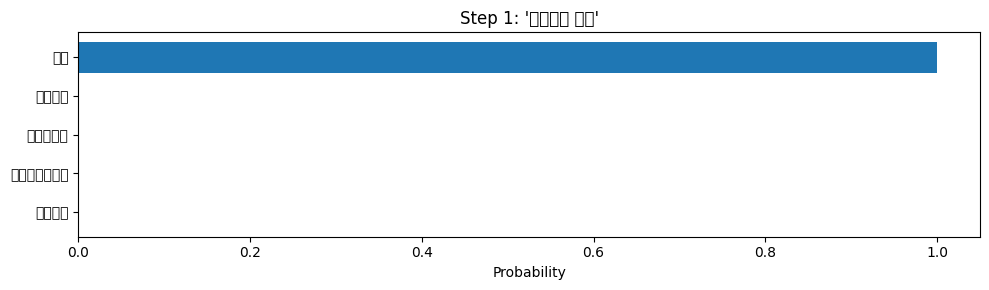

<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.

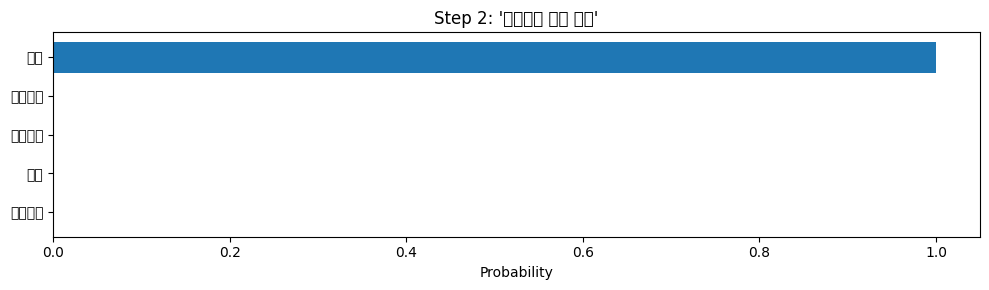

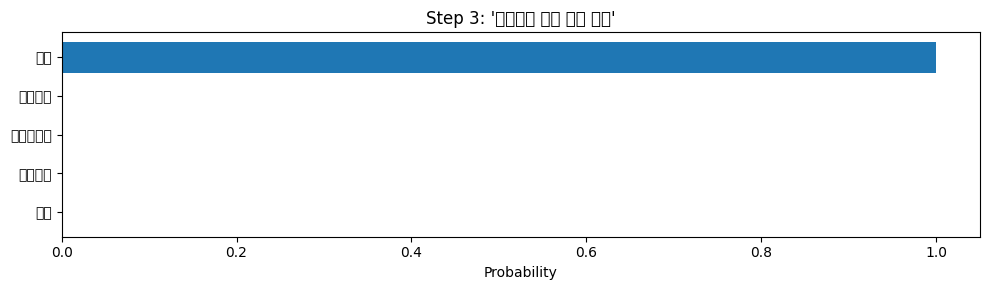

<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2370 (\N{DEVANAGARI VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2370 (\N{DEVANAGARI VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWar

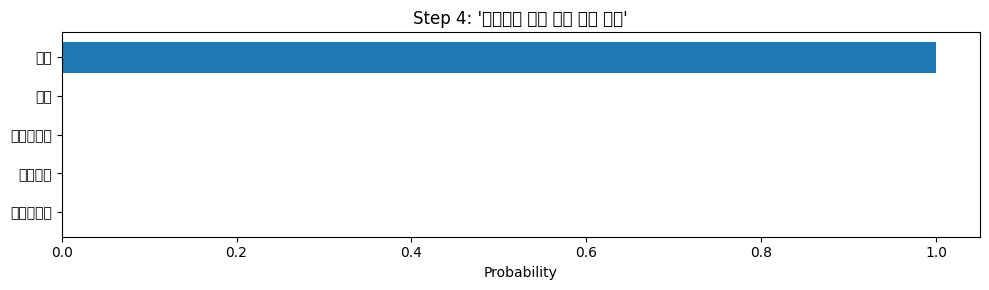

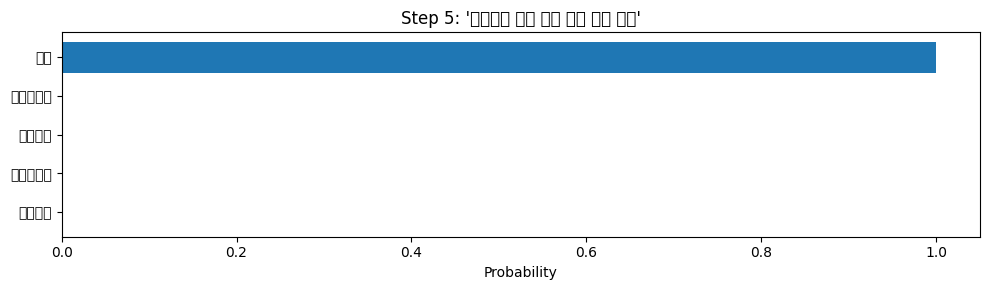

<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2330 (\N{DEVANAGARI LETTER CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2371 (\N{DEVANAGARI VOWEL SIGN VOCALIC R}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2326 (\N{DEVANAGARI LETTER KHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) mis

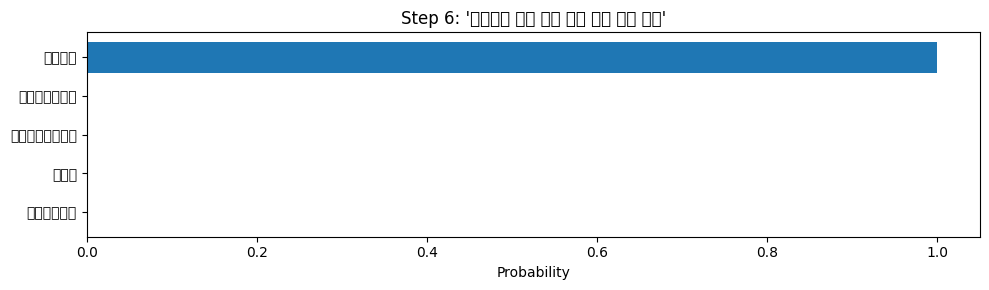

<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-ae823aec50a6>:92: UserWarning: Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


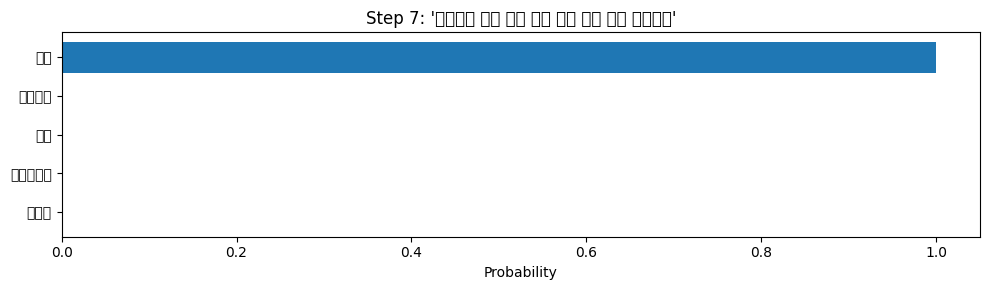

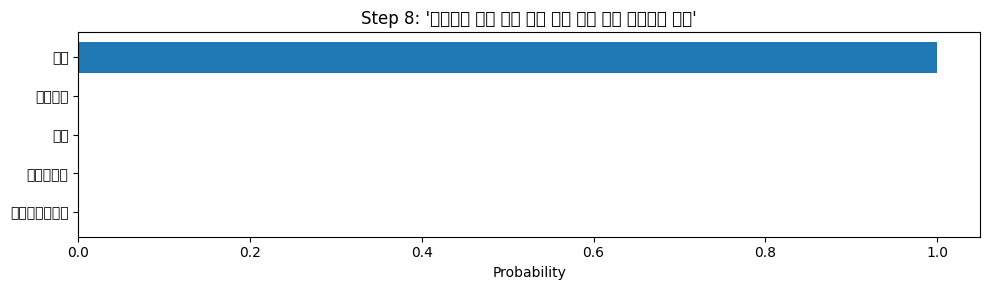

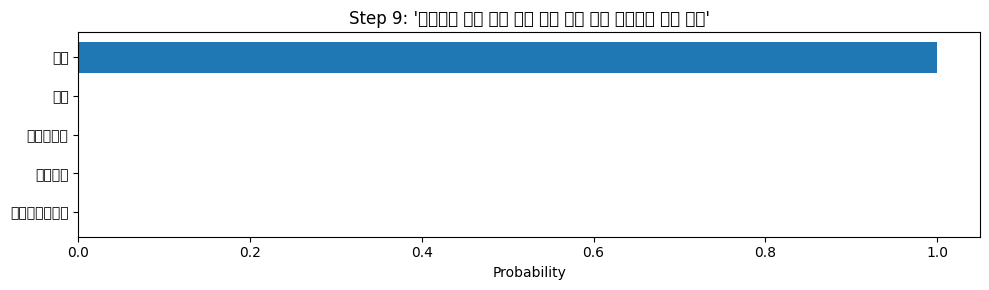

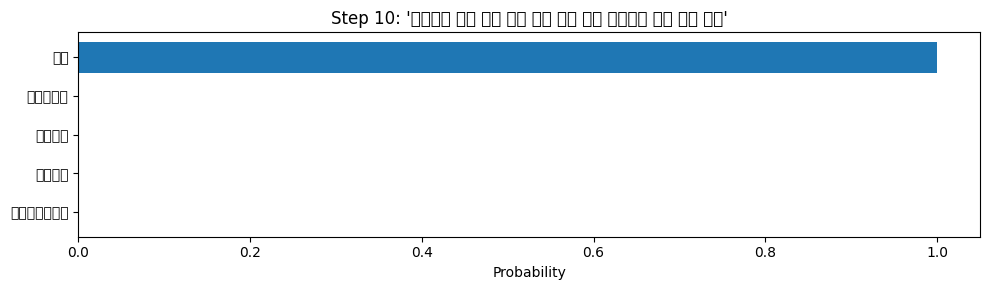


Final Generated Text with Visualization:
भारत एक एक एक एक एक एक भारत एक एक एक एक


In [ ]:
# 1. Fix repetitive generation by implementing top-k sampling
def generate_hindi_text(model, tokenizer, prompt, max_length=50, temperature=0.7, device='cpu', top_k=50):
    """
    Generate Hindi text with top-k sampling to avoid repetition
    """
    # Preprocess and tokenize prompt
    clean_prompt = tokenizer.preprocess_hindi_text(prompt)
    encoded = tokenizer.encode(clean_prompt, add_special_tokens=False)
    input_ids = torch.tensor([encoded["ids"]], dtype=torch.long, device=device)

    # Generate continuation with top-k sampling
    model.eval()
    with torch.no_grad():
        generated = input_ids
        for _ in range(max_length):
            # Get model predictions
            logits = model(generated)[:, -1, :]

            # Apply temperature and top-k filtering
            logits = logits / temperature
            top_logits, top_indices = logits.topk(top_k, dim=-1)
            probs = torch.softmax(top_logits, dim=-1)

            # Sample from top-k tokens
            next_token = top_indices.gather(-1, torch.multinomial(probs, 1))
            generated = torch.cat([generated, next_token], dim=-1)

    # Decode and combine with prompt
    generated_ids = generated[0].tolist()
    continuation = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return prompt + continuation[len(clean_prompt):]

# 2. Fix font warnings by installing Hindi fonts
!sudo apt-get install fonts-lohit-devanagari -qq
!sudo fc-cache -fv

# 3. Update the visualization function to use installed fonts
def generate_and_visualize_probabilities(model, tokenizer, prompt, max_length=10,
                                        top_k=5, temperature=0.7, device='cpu'):
    """
    Generate text with probability visualization using proper Hindi fonts
    """
    # Set up matplotlib with Hindi font
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    # Find and use Hindi font
    hindi_font = None
    for font in fm.findSystemFonts():
        if 'Lohit' in font or 'Devanagari' in font:
            hindi_font = fm.FontProperties(fname=font)
            break

    if not hindi_font:
        print("Hindi font not found, using default")
        hindi_font = None

    # Preprocess and tokenize prompt
    clean_prompt = tokenizer.preprocess_hindi_text(prompt)
    encoded = tokenizer.encode(clean_prompt, add_special_tokens=False)
    input_ids = torch.tensor([encoded["ids"]], dtype=torch.long, device=device)

    # Generate step by step
    model.eval()
    generated = input_ids
    generated_text = prompt

    for step in range(max_length):
        with torch.no_grad():
            logits = model(generated)[:, -1, :]

        # Apply temperature
        logits = logits / temperature
        probs = torch.softmax(logits, dim=-1)

        # Get top-k predictions
        top_probs, top_indices = probs.topk(top_k, dim=-1)
        top_tokens = [tokenizer.inverse_vocab.get(idx.item(), "[UNK]")
                      for idx in top_indices[0]]

        # Visualize probabilities
        plt.figure(figsize=(10, 3))
        plt.barh(top_tokens[::-1], top_probs[0].tolist()[::-1])
        plt.title(f"Step {step+1}: '{generated_text}'")
        plt.xlabel("Probability")

        if hindi_font:
            for label in plt.gca().get_yticklabels():
                label.set_fontproperties(hindi_font)

        plt.tight_layout()
        plt.show()

        # Sample next token
        next_token = torch.multinomial(probs, 1)
        generated = torch.cat([generated, next_token], dim=-1)

        # Update generated text
        new_token = tokenizer.inverse_vocab.get(next_token[0,0].item(), "")
        generated_text += " " + new_token if new_token else ""

    return generated_text

# 4. Example Usage Block (Updated)

# Define paths (adjust if your output directory is different)
MODEL_OUTPUT_DIR = "model_output"
TOKENIZER_PATH = os.path.join(MODEL_OUTPUT_DIR, "hindi_tokenizer.json")
MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, "hindi_tokenizer_model_best.pt") # Use the best saved model

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Initialize variables to None in case loading fails
loaded_model = None
loaded_tokenizer = None

try:
    # Ensure the model and tokenizer classes are defined
    loaded_model, loaded_tokenizer = load_model_and_tokenizer(MODEL_PATH, TOKENIZER_PATH, DEVICE)
except NameError as e:
    print(f"Error: {e}. Make sure necessary classes are defined.")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure files exist in {MODEL_OUTPUT_DIR}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Generate Text
if loaded_model is not None and loaded_tokenizer is not None:
    user_prompt = input("Enter your Hindi prompt (e.g., भारत एक): ") or "भारत एक"
    print(f"Using prompt: {user_prompt}")

    print("\n--- Generating Text (Standard) ---")
    generated_output = generate_hindi_text(
        model=loaded_model,
        tokenizer=loaded_tokenizer,
        prompt=user_prompt,
        max_length=50,
        temperature=0.7,
        top_k=50,  # Add top-k sampling
        device=DEVICE
    )
    print("\nFinal Generated Text:")
    print(generated_output)

    print("\n--- Generating Text with Probability Visualization ---")
    viz_output = generate_and_visualize_probabilities(
        model=loaded_model,
        tokenizer=loaded_tokenizer,
        prompt=user_prompt,
        max_length=10,
        top_k=5,
        temperature=0.7,
        device=DEVICE
    )
    print("\nFinal Generated Text with Visualization:")
    print(viz_output)
else:
    print("Skipping generation as model/tokenizer failed to load.")